In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
a = []
i = '1'
while(1):
  a.append(i)

In [0]:
rootFolder = 'drive/My Drive/pk_img/' 

In [16]:
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

train_on_gpu = True if torch.cuda.is_available() else False
train_on_gpu

True

drive/My Drive/pk_img/216.jpg


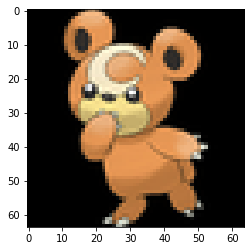

In [17]:
a = ''
for file in os.listdir(rootFolder):
    a = file
    break
dir = rootFolder + a
print(dir)
a = Image.open(dir)
# a = a.convert('RGB')
a.thumbnail((64, 64), Image.ANTIALIAS)
plt.imshow(a)
plt.show()

In [0]:
transform = transforms.Compose([
                        transforms.Resize(size=(64, 64)),
                        transforms.ToTensor()
                            ])
images = datasets.ImageFolder(root=rootFolder, transform=transform)

In [0]:
pokImg = torch.utils.data.DataLoader(images, batch_size=32, num_workers=0, shuffle=True)

In [0]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False):
    layers = []
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv)
    if batch_norm:
        batch_norm_layer = nn.BatchNorm2d(out_channels)
        layers.append(batch_norm_layer)
        
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        ## 64x64x3
        self.conv1 = conv(3, conv_dim) ## 32x32x32
        self.conv2 = conv(conv_dim, conv_dim*2, batch_norm=True) ## 16x16x64
        self.conv3 = conv(conv_dim*2, conv_dim*4, batch_norm=True) ## 8x8x128
        self.conv4 = conv(conv_dim*4, conv_dim*8, batch_norm=True) ## 4x4x256
#         self.conv5 = conv(conv_dim*8, conv_dim*16) ## 4x4x512
        
        
        self.fc = nn.Linear(conv_dim*8*4*4, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
#         x = F.leaky_relu(self.conv5(x), 0.2)
        
        x = x.view(-1, 4*4*256)
        x = self.fc(x)
        
        return x
    

In [0]:
def deconv(in_channel, out_channel, kernel_size=4, stride=2, padding=1, batch_norm=False):
    layers = []
    decon = nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias=False)
    layers.append(decon)
    if batch_norm:
        batch_layer = nn.BatchNorm2d(out_channel)
        layers.append(batch_layer)
        
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        
        self.fc = nn.Linear(z_size, 4*4*16*conv_dim)
        ## 4x4x512
        self.deconv1 = deconv(conv_dim*16, conv_dim*8, batch_norm=True) ## 8x8x256
        self.deconv2 = deconv(conv_dim*8, conv_dim*4, batch_norm=True) ## 16x16x128
        self.deconv3 = deconv(conv_dim*4, conv_dim*2, batch_norm=True) ## 32x32x64
        self.deconv4 = deconv(conv_dim*2, conv_dim, batch_norm=True) ## 64x64x32
        self.deconv5 = deconv(conv_dim, 3, kernel_size=3, stride=1) ## 64x64x3
        
    def forward(self, x):
        x = self.fc(x)
        
        x = x.view(-1, 512, 4, 4)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = F.tanh(self.deconv5(x))
        
        return x
        

In [24]:
z_size = 100
D = Discriminator()
G = Generator(z_size)

if train_on_gpu:
    # move models to GPU
    print('Moving to GPU\n')
    G.cuda()
    D.cuda()

print(D)
print()
print(G)

Moving to GPU

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [0]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [0]:
# lr_g = 0.0002
# lr_d = 0.00004
lr = 0.0002
beta1 = 0.5
beta2 = 0.99

d_optim = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optim = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [0]:
def scale(x):
    x = x*2 -1
    
    return x

In [28]:
import pickle as pkl 

n_epochs = 500
z_size = 100
samples = []
losses = []
print_every = 300
sample_size=8
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

for epoch in range(n_epochs):
    for batch_index, (real_images,_) in enumerate(pokImg):

        batch_size = real_images.size(0)
        real_img = scale(real_images)

        ## DISCRIMINATOR LOSS ##
        d_optim.zero_grad()
        if train_on_gpu:
            real_img = real_img.cuda()

        real_pred = D(real_img)
        r_loss = real_loss(real_pred, smooth=True)

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_img = G(z)
        fake_pred = D(fake_img)
        f_loss = fake_loss(fake_pred)

        d_loss = r_loss + f_loss
        d_loss.backward()
        d_optim.step()

        ## GENERATOR LOSS ##
        g_optim.zero_grad()

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_img = G(z)
        ## Taking loss with flipped lables or real loss function to trick the D
        fake_pred = D(fake_img)
        f_loss_g = real_loss(fake_pred)

        g_loss = f_loss_g
        g_loss.backward()
        g_optim.step()

        if batch_index % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, n_epochs, d_loss.item(), g_loss.item()))
    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode
    
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
        

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  500] | d_loss: 1.4917 | g_loss: 1.0259
Epoch [    2/  500] | d_loss: 0.3998 | g_loss: 5.8271
Epoch [    3/  500] | d_loss: 0.3679 | g_loss: 6.2757
Epoch [    4/  500] | d_loss: 0.6603 | g_loss: 9.7519
Epoch [    5/  500] | d_loss: 1.1848 | g_loss: 10.4250
Epoch [    6/  500] | d_loss: 1.0963 | g_loss: 2.5779
Epoch [    7/  500] | d_loss: 0.7231 | g_loss: 1.9464
Epoch [    8/  500] | d_loss: 1.0308 | g_loss: 4.0744
Epoch [    9/  500] | d_loss: 0.7130 | g_loss: 2.3284
Epoch [   10/  500] | d_loss: 0.9711 | g_loss: 3.3505
Epoch [   11/  500] | d_loss: 0.8566 | g_loss: 1.9267
Epoch [   12/  500] | d_loss: 1.0472 | g_loss: 1.1541
Epoch [   13/  500] | d_loss: 0.7796 | g_loss: 2.8768
Epoch [   14/  500] | d_loss: 1.3294 | g_loss: 3.9592
Epoch [   15/  500] | d_loss: 0.9472 | g_loss: 3.6826
Epoch [   16/  500] | d_loss: 0.6724 | g_loss: 2.1452
Epoch [   17/  500] | d_loss: 0.6896 | g_loss: 2.6265
Epoch [   18/  500] | d_loss: 0.7563 | g_loss: 3.0162
Epoch [   19/  500] | d_los

RuntimeError: ignored

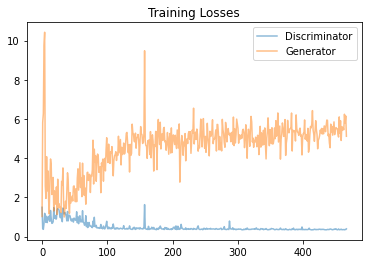

In [29]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
      img = img.detach().cpu().numpy()
      img = np.transpose(img, (1, 2, 0))
      img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
      # print(min(img), max(img))
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)
      im = ax.imshow(img.reshape((64,64,3)))

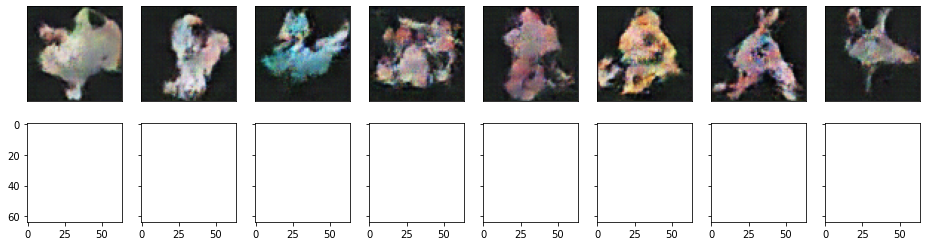

In [31]:
_ = view_samples(-1, samples)